Maze Problem:

Created sample file: maze1.txt

███████████
█A    █   █
█ ██ ███ ██
█    █    █
████ ██ █B█
█         █
███████████

States explored: 26

███████████
█A    █   █
█*██ ███ ██
█****█    █
████*██ █B█
█   ******█
███████████



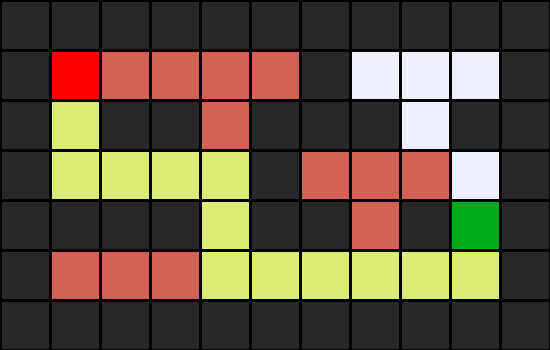

In [5]:
# ----- Data structure for each node (cell) in the search -----
class Node:
    def __init__(self, state, parent, action):
        self.state = state      # (row, col) coordinates of this cell
        self.parent = parent    # reference to the Node we came from
        self.action = action    # move taken from parent to reach this cell


# ----- Frontier using a stack (for Depth-First Search) -----
class StackFrontier:
    def __init__(self):
        self.frontier = []      # list to store nodes waiting to explore

    def add(self, node):
        self.frontier.append(node)                 # push a new node

    def contains_state(self, state):
        # check if any node in frontier has the given cell state
        return any(node.state == state for node in self.frontier)

    def empty(self):
        return len(self.frontier) == 0            # True if no nodes left

    def remove(self):
        # pop the last node (LIFO) → Depth-First behaviour
        if self.empty():
            raise Exception("empty frontier")
        node = self.frontier[-1]
        self.frontier = self.frontier[:-1]
        return node


# ----- Frontier using a queue (for Breadth-First Search) -----
class QueueFrontier(StackFrontier):
    def remove(self):
        # pop the first node (FIFO) → Breadth-First behaviour
        if self.empty():
            raise Exception("empty frontier")
        node = self.frontier[0]
        self.frontier = self.frontier[1:]
        return node


# ----- Maze class: loads maze, solves it, and draws output -----
class Maze:
    def __init__(self, filename):
        # read entire text file
        with open(filename) as f:
            contents = f.read()

        # validate that there is exactly one start 'A' and one goal 'B'
        if contents.count("A") != 1:
            raise Exception("maze must have exactly one start point")
        if contents.count("B") != 1:
            raise Exception("maze must have exactly one goal")

        # split text into lines and measure maze size
        contents = contents.splitlines()
        self.height = len(contents)                      # number of rows
        self.width = max(len(line) for line in contents) # longest row

        # build a 2-D list of booleans to mark walls
        self.walls = []
        for i in range(self.height):
            row = []
            for j in range(self.width):
                try:
                    if contents[i][j] == "A":
                        self.start = (i, j)    # record start position
                        row.append(False)      # not a wall
                    elif contents[i][j] == "B":
                        self.goal = (i, j)     # record goal position
                        row.append(False)
                    elif contents[i][j] == " ":
                        row.append(False)      # open space
                    else:
                        row.append(True)       # wall
                except IndexError:
                    # if line is shorter than width, treat as empty
                    row.append(False)
            self.walls.append(row)

        self.solution = None  # will hold final (actions, path) later

    # print maze to console with optional solution path
    def print(self):
        solution = self.solution[1] if self.solution else None
        print()
        for i, row in enumerate(self.walls):
            for j, col in enumerate(row):
                if col:                      # wall
                    print("█", end="")
                elif (i, j) == self.start:   # start point
                    print("A", end="")
                elif (i, j) == self.goal:    # goal point
                    print("B", end="")
                elif solution and (i, j) in solution:  # path cell
                    print("*", end="")
                else:                        # empty cell
                    print(" ", end="")
            print()
        print()

    # return list of valid neighboring cells and their actions
    def neighbors(self, state):
        row, col = state
        candidates = [("up",(row-1,col)), ("down",(row+1,col)),
                      ("left",(row,col-1)), ("right",(row,col+1))]
        result = []
        for action, (r, c) in candidates:
            if 0 <= r < self.height and 0 <= c < self.width and not self.walls[r][c]:
                result.append((action, (r, c)))
        return result

    # search for a path using BFS (default) or DFS
    def solve(self, method="bfs"):
        self.num_explored = 0
        start = Node(state=self.start, parent=None, action=None)

        # choose frontier type: queue for BFS, stack for DFS
        frontier = QueueFrontier() if method.lower() == "bfs" else StackFrontier()
        frontier.add(start)

        self.explored = set()  # set of visited cells

        while True:
            if frontier.empty():                # no path exists
                raise Exception("no solution")

            node = frontier.remove()            # get next node
            self.num_explored += 1

            if node.state == self.goal:         # reached goal
                actions, cells = [], []
                # backtrack through parents to build path
                while node.parent is not None:
                    actions.append(node.action)
                    cells.append(node.state)
                    node = node.parent
                actions.reverse()
                cells.reverse()
                self.solution = (actions, cells)
                return

            self.explored.add(node.state)       # mark as visited

            # add unexplored neighbors to frontier
            for action, state in self.neighbors(node.state):
                if state not in self.explored and not frontier.contains_state(state):
                    child = Node(state=state, parent=node, action=action)
                    frontier.add(child)

    # create an image of the maze with path/explored cells colored
    def output_image(self, filename, show_solution=True, show_explored=False):
        from PIL import Image, ImageDraw
        cell_size, cell_border = 50, 2
        img = Image.new("RGBA",
                        (self.width*cell_size, self.height*cell_size),
                        "black")
        draw = ImageDraw.Draw(img)
        solution = self.solution[1] if self.solution else None
        for i, row in enumerate(self.walls):
            for j, col in enumerate(row):
                if col: fill = (40,40,40)                       # wall
                elif (i,j) == self.start: fill = (255,0,0)      # start red
                elif (i,j) == self.goal:  fill = (0,171,28)     # goal green
                elif solution and show_solution and (i,j) in solution:
                    fill = (220,235,113)                        # path yellow
                elif solution and show_explored and (i,j) in self.explored:
                    fill = (212,97,85)                          # explored pink
                else: fill = (237,240,252)                      # empty cell
                draw.rectangle(
                    [(j*cell_size+cell_border, i*cell_size+cell_border),
                     ((j+1)*cell_size-cell_border, (i+1)*cell_size-cell_border)],
                    fill=fill)
        img.save(filename)   # save PNG file


# ----- Create a sample maze text file -----
sample = """###########
#A    #   #
# ## ### ##
#    #    #
#### ## #B#
#         #
###########"""
open("maze1.txt","w").write(sample)   # write maze layout to a file
print("Created sample file: maze1.txt")

# ----- Solve and display the maze -----
from IPython.display import Image as IPImage, display

m = Maze("maze1.txt")            # load maze from file
m.print()                        # print initial maze
m.solve(method="bfs")            # find path using Breadth-First Search
print("States explored:", m.num_explored)
m.print()                        # print maze with solution path
m.output_image("maze.png", show_explored=True)  # save colored PNG
display(IPImage("maze.png"))     # display the image inside notebook
